In [1]:
import sys
from pathlib import Path

# Get the current notebook's directory
parent = Path().resolve()  # Current working directory (notebook's directory)
root = parent.parent.parent       # Go one level up

print("Current Directory:", parent)
print("Parent Directory:", root)

# Optionally append to sys.path
sys.path.append(str(root))


Current Directory: D:\mukul\Desktop\Unimelb\Masters\Capstone\Learning-Dynamic-Systems\indirect_identification\notebooks
Parent Directory: D:\mukul\Desktop\Unimelb\Masters\Capstone\Learning-Dynamic-Systems


# param to theta

In [2]:
import numpy as np
n_states = 4
n_inputs = 2
n_output = 2
noise_order = 1
n_params = n_states + n_states*n_inputs + n_output*(noise_order+1)
print("total_params:", n_params)
C = np.array([[0,0,0,1],[0,1,0,0]])
def _construct_ss_from_params(params,C):
    """
    Returns state space matrices A_obs,B_obs,C_obs,D_obs and the A,B polynomials
    """
    # A: n_state x n_state matrix
    A =  params[:n_states]
    A_obs = np.hstack([np.vstack([np.zeros(n_states-1), np.eye(n_states-1)]), -np.flipud(A.reshape(A.size,-1))])
    # B: n_state x n_input matrix
    B = params[n_states:n_states+n_states*n_inputs].reshape(n_inputs,n_states)
    B_obs = np.flipud(B.T)
    # C: n_output x n_state matrix
    C_obs = C
    # D: n_output x n_input matrix: zero matrix for now
    D_obs = np.zeros((n_output,n_inputs))

    A = np.hstack([1, A])
    B = np.hstack([np.zeros((n_inputs,1)), B])

    return A_obs, B_obs, C_obs, D_obs, A,B
    


params = np.array([1,2,3,4,11,12,13,14,21,22,23,24,31,32,33,34])
A_obs, B_obs, C_obs, D_obs, A,B = _construct_ss_from_params(params,C)
print("A_obs: ", A_obs)
print("B_obs:",  B_obs)
print("C_obs: ", C_obs)
print("A",A)
print("B", B)

total_params: 16
A_obs:  [[ 0.  0.  0. -4.]
 [ 1.  0.  0. -3.]
 [ 0.  1.  0. -2.]
 [ 0.  0.  1. -1.]]
B_obs: [[14 24]
 [13 23]
 [12 22]
 [11 21]]
C_obs:  [[0 0 0 1]
 [0 1 0 0]]
A [1 1 2 3 4]
B [[ 0. 11. 12. 13. 14.]
 [ 0. 21. 22. 23. 24.]]


In [3]:
C = np.empty((n_output, noise_order+1))
if n_output == 1:
    # if only one output, H is a scalar transfer function
    # H = np.zeros((n_states, n_states), dtype=object)
    j = n_states + n_states*n_inputs
    num = params[j:j+(noise_order+1)]
    den = A
    C[0]=num
    print(num, den)
else:
    H = np.zeros((n_output, n_output), dtype=object)
    for i in range(n_output):
        j = n_states + n_states*n_inputs + i*(noise_order+1)
        # numerator and denominator of the transfer function
        num = params[j:j+noise_order+1]
        den = A
        C[i]=num
        print("num:",num)
        print("den",den)
print(C)

num: [31 32]
den [1 1 2 3 4]
num: [33 34]
den [1 1 2 3 4]
[[31. 32.]
 [33. 34.]]


# SISO

In [91]:
import numpy as np
def create_phi_optimized(Y: np.ndarray, U: np.ndarray, n_a: int, n_b: int, c: float) -> np.ndarray:
    """
    Create the phi matrix optimized for the given inputs.
    
    Parameters:
    Y (array): The output sequence.
    U (array): The input sequence.
    n_a (int): The number of lags for the output sequence.
    n_b (int): The number of lags for the input sequence.
    
    Returns:
    array: The phi matrix.
    """
    t = Y.shape[0]
    
    # Initialize phi with zeros
    phi = np.zeros(shape=[t, n_a + n_b], dtype=Y.dtype)
    
    # Handle Y lags
    for i in range(1, n_a + 1):
        phi[i:, i-1] = -Y[:-i]/c
    
    # Handle U lags
    for i in range(1, n_b + 1):
        phi[i:, n_a+i-1] = U[:-i]/c
    
    return phi

Y = np.random.rand(10)
U = np.random.rand(10)
print(Y)

phi = create_phi_optimized(Y,U,2,3,2)
print(phi)
print(phi.shape)


from numba import njit
@njit()
def create_phi_optimized_n(Y: np.ndarray, U: np.ndarray, n_a: int, n_b: int, c: float) -> np.ndarray:
    """
    Create the phi matrix optimized for the given inputs.
    
    Parameters:
    Y (array): The output sequence.
    U (array): The input sequence.
    n_a (int): The number of lags for the output sequence.
    n_b (int): The number of lags for the input sequence.
    
    Returns:
    array: The phi matrix.
    """
    t = Y.shape[0]
    
    # Initialize phi with zeros
    phi = np.zeros((t, n_a + n_b), dtype=Y.dtype)
    
    # Handle Y lags
    for i in range(1, n_a + 1):
        phi[i:, i-1] = -Y[:-i]/c
    
    # Handle U lags
    for i in range(1, n_b + 1):
        phi[i:, n_a+i-1] = U[:-i]/c
    
    return phi


@njit(cache=True)
def create_phi_optimized_n2(Y: np.ndarray, U: np.ndarray, n_a: int, n_b: int, c: float) -> np.ndarray:
    """
    Create the phi matrix optimized for the given inputs using Numba-friendly loops.
    
    Parameters:
    Y (array): The output sequence.
    U (array): The input sequence.
    n_a (int): Number of Y lags.
    n_b (int): Number of U lags.
    c (float): Normalization constant.
    
    Returns:
    array: The phi matrix.
    """
    t = Y.shape[0]
    phi = np.zeros((t, n_a + n_b), dtype=Y.dtype)
    # Output lags (Y)
    for lag in range(1, n_a + 1):
        for i in range(lag, t):
            phi[i, lag - 1] = -Y[i - lag] / c
    # Input lags (U)
    for lag in range(1, n_b + 1):
        for i in range(lag, t):
            phi[i, n_a + lag - 1] = U[i - lag] / c
    return phi
phi = create_phi_optimized_n(Y,U,2,3,2)
print(phi)
print(phi.shape)

ph2 = create_phi_optimized_n2(Y,U,2,3,2)
print(ph2)
print(np.all(phi==ph2))

from cupyx.profiler import benchmark

print(benchmark(create_phi_optimized,(Y,U,2,3,2), n_repeat=1000))
print(benchmark(create_phi_optimized_n,(Y,U,2,3,2), n_repeat=10000))
print(benchmark(create_phi_optimized_n2,(Y,U,2,3,2), n_repeat=10000))

[0.83733671 0.42523882 0.51389669 0.73147137 0.27298609 0.31157385
 0.76144324 0.46930391 0.94289018 0.90789412]
[[ 0.          0.          0.          0.          0.        ]
 [-0.41866835  0.          0.35786765  0.          0.        ]
 [-0.21261941 -0.41866835  0.42625594  0.35786765  0.        ]
 [-0.25694835 -0.21261941  0.38775244  0.42625594  0.35786765]
 [-0.36573569 -0.25694835  0.11677996  0.38775244  0.42625594]
 [-0.13649305 -0.36573569  0.09577561  0.11677996  0.38775244]
 [-0.15578692 -0.13649305  0.37896326  0.09577561  0.11677996]
 [-0.38072162 -0.15578692  0.14273773  0.37896326  0.09577561]
 [-0.23465195 -0.38072162  0.05120033  0.14273773  0.37896326]
 [-0.47144509 -0.23465195  0.33286499  0.05120033  0.14273773]]
(10, 5)
[[ 0.          0.          0.          0.          0.        ]
 [-0.41866835  0.          0.35786765  0.          0.        ]
 [-0.21261941 -0.41866835  0.42625594  0.35786765  0.        ]
 [-0.25694835 -0.21261941  0.38775244  0.42625594  0.357867

In [46]:
from scipy.signal import lfilter
from indirect_identification.tf_methods.fast_tfs_methods_fast_math import _convolve
@njit()
def create_phi_optimized_noise(Y: np.ndarray, U: np.ndarray, N: np.ndarray, n_a: int, n_b: int, n_c: int) -> np.ndarray:
    """
    Create the phi matrix optimized for the given inputs using Numba-friendly loops.
    
    Parameters:
    Y (array): The output sequence.
    U (array): The input sequence.
    n_a (int): Number of Y lags.
    n_b (int): Number of U lags.
    c (float): Normalization constant.
    
    Returns:
    array: The phi matrix.
    """
    t = Y.shape[0]
    n_a = n_a -1
    n_b = n_b -1
    n_c = n_c 
    print(n_a,n_b,n_c)
    phi = np.zeros((t, n_a + n_b +n_c ), dtype=Y.dtype)
    print(phi.shape)
    # Output lags (Y)
    for lag in range(1, n_a+1):
        for i in range(lag, t):
            phi[i, lag - 1] = Y[i - lag]
    # Input lags (U)
    for lag in range(1, n_b+1):
        for i in range(lag, t):
            phi[i, n_a + lag - 1] = -U[i - lag] 
    for lag in range(n_c+1):
        for i in range(lag, t):
            phi[i, n_a+n_b+lag]= -N[i-lag]
    return phi.T
# AR, X, and MA coefficients
A = np.array([1, 0.3, -0.2])    # a1, a2
B = np.array([0, 0.5, 0.1])     # b1, b2
C = np.array([2])          # c1

A_Y = lfilter(A,[1], Y)
B_U = lfilter(B,[1], U)
eps_t = A_Y - B_U
phi = create_phi_optimized_noise(Y,U,eps_t, len(A),len(B),len(C))
print(phi)

for i in range(len(A)+len(B)-3):
    phi[i] = lfilter([1],C, phi[i])

C2 = _convolve(C,C)
for i in range(len(C)):
    phi[-i-1] = lfilter([1], C2, phi[-i-1])

print(phi)

2 2 1
(10, 5)
[[ 0.          0.10892117 -0.10892117  0.17856424 -0.03184901  0.06096704
  -0.62760425  0.08354911  0.35925221  0.04871118]
 [ 0.          0.          0.10892117  0.08658181  0.3914243   0.10569964
   0.92535736  0.12273985  0.14094661  0.26958507]
 [ 0.         -0.5956448  -0.60840225 -0.41187477 -0.41998132 -0.84151622
  -0.53559536 -0.56494545 -0.25552949 -0.07913766]
 [ 0.          0.         -0.5956448  -0.60840225 -0.41187477 -0.41998132
  -0.84151622 -0.53559536 -0.56494545 -0.25552949]
 [-0.10892117  0.17856424 -0.03184901  0.06096704 -0.62760425  0.08354911
   0.35925221  0.04871118 -0.51891034 -0.9494346 ]]
[[ 0.          0.05446059 -0.05446059  0.08928212 -0.0159245   0.03048352
  -0.31380213  0.04177455  0.1796261   0.02435559]
 [ 0.          0.          0.05446059  0.04329091  0.19571215  0.05284982
   0.46267868  0.06136993  0.0704733   0.13479253]
 [ 0.         -0.2978224  -0.30420112 -0.20593739 -0.20999066 -0.42075811
  -0.26779768 -0.28247273 -0.1277647

In [138]:
import numpy as np
from numba import njit
from cupyx.profiler import benchmark
@njit(cache=True, fastmath=True)
def lfilter_numba(b, a, x):
    N = len(a)
    M = len(b)
    n = len(x)

    if a[0] != 1.0:
        b = b / a[0]
        a = a / a[0]

    y = np.zeros(n)

    for i in range(n):
        for j in range(M):
            if i - j >= 0:
                y[i] += b[j] * x[i - j]
        for j in range(1, N):
            if i - j >= 0:
                y[i] -= a[j] * y[i - j]

    return y

from scipy.signal import lfilter

# Example filter coefficients
b = np.array([0.1, 0.2, 0.3])
a = np.array([1.0, -0.3, 0.2])

# Input signal
x = np.random.randn(1000)

# Compare with scipy
y_scipy = lfilter(b, a, x)
y_numba = lfilter_numba(b, a, x)

# Check difference
print("Max error:", np.max(np.abs(y_scipy - y_numba)))
print("Median error:",  np.median(np.abs(y_scipy - y_numba)))
print(benchmark(lfilter,(b, a, x), n_repeat=10000))
print(benchmark(lfilter_numba,(b, a, x), n_repeat=10000))

Max error: 4.440892098500626e-16
Median error: 2.42861286636753e-17
lfilter             :    CPU:    30.057 us   +/- 59.145 (min:    18.500 / max:  5239.600) us     GPU-0:    59.147 us   +/- 162.997 (min:     2.176 / max:  7168.416) us
lfilter_numba       :    CPU:    14.906 us   +/-  3.816 (min:    10.700 / max:    69.600) us     GPU-0:    37.525 us   +/- 84.979 (min:     2.176 / max:  2439.136) us


In [142]:
from scipy.signal import lfilter
from indirect_identification.tf_methods.fast_tfs_methods_fast_math import _convolve
from numba import prange
@njit(cache=True, fastmath=True)
def create_phi_optimized_filter(Y: np.ndarray, U: np.ndarray, A: np.ndarray, B: np.ndarray, C:np.ndarray) -> np.ndarray:
    """
    Create the phi matrix optimized for the given inputs using Numba-friendly loops.
    
    Parameters:
    Y (array): The output sequence.
    U (array): The input sequence.
    n_a (int): Number of Y lags.
    n_b (int): Number of U lags.
    c (float): Normalization constant.
    
    Returns:
    array: The phi matrix.
    """
    t = Y.shape[0]
    n_a = len(A) -1
    n_b = len(B) -1
    n_c = len(C) 
    num = np.array([1.0])
    phi = np.zeros((t, n_a + n_b +n_c ), dtype=Y.dtype)
    filtered_Y = lfilter_numba(num, C, Y)
    filtered_U = lfilter_numba(num, C, U)
    A_Y = lfilter_numba(A,C, filtered_Y)
    B_U = lfilter_numba(B,C, filtered_U)
    eps_t = A_Y - B_U
    # Output lags (Y)
    for lag in range(1, n_a+1):
        for i in range(lag, t):
            phi[i, lag - 1] = filtered_Y[i - lag]
    # Input lags (U)
    for lag in range(1, n_b+1):
        for i in range(lag, t):
            phi[i, n_a + lag - 1] = -filtered_U[i - lag] 
    for lag in range(n_c):
        for i in range(lag, t):
            phi[i, n_a+n_b+lag]= -eps_t[i-lag]
    return phi

@njit(cache=True,fastmath=True)
def create_phi_optimized_filter2(Y, U, A, B, C):
    t = Y.shape[0]
    n_a = len(A) - 1
    n_b = len(B) - 1
    n_c = len(C)

    idx_b = n_a
    idx_c = n_a + n_b

    phi = np.zeros((t, idx_c + n_c), dtype=np.float64)

    ones = np.empty(1, dtype=np.float64)
    ones[0] = 1.0

    filtered_Y = lfilter_numba(ones, C, Y)
    filtered_U = lfilter_numba(ones, C, U)
    A_Y = lfilter_numba(A, C, filtered_Y)
    B_U = lfilter_numba(B, C, filtered_U)
    eps_t = A_Y - B_U

    for i in range(t):
        if i > 0:
            for lag in range(1, n_a + 1):
                    phi[i, lag - 1] = filtered_Y[i - lag]
            for lag in range(1, n_b + 1):
                    phi[i, idx_b + lag - 1] = -filtered_U[i - lag]
        for lag in range(n_c):
                phi[i, idx_c + lag] = -eps_t[i - lag]

    return phi


# AR, X, and MA coefficients
A = np.array([1.0, 0.3, -0.2])    # a1, a2
B = np.array([0, 0.5, 0.1])     # b1, b2
C = np.array([2.0])          # c1


print(Y)

phi = create_phi_optimized_filter(Y,U, A, B, C)
print(phi)
phi = create_phi_optimized_filter2(Y,U, A, B, C)
print(phi)


print(benchmark(create_phi_optimized_filter,(Y,U, A, B, C), n_repeat=100000))
print(benchmark(create_phi_optimized_filter2,(Y,U, A, B, C), n_repeat=100000))


[0.83733671 0.42523882 0.51389669 0.73147137 0.27298609 0.31157385
 0.76144324 0.46930391 0.94289018 0.90789412]
[[ 0.          0.          0.          0.         -0.20933418]
 [ 0.41866835  0.         -0.35786765  0.         -0.07964305]
 [ 0.21261941  0.41866835 -0.42625594 -0.35786765  0.00595712]
 [ 0.25694835  0.21261941 -0.38775244 -0.42625594 -0.08189725]
 [ 0.36573569  0.25694835 -0.11677996 -0.38775244 -0.04882943]
 [ 0.13649305  0.36573569 -0.09577561 -0.11677996 -0.03201095]
 [ 0.15578692  0.13649305 -0.37896326 -0.09577561 -0.10054995]
 [ 0.38072162  0.15578692 -0.14273773 -0.37896326 -0.10422293]
 [ 0.23465195  0.38072162 -0.05120033 -0.14273773 -0.21291121]
 [ 0.47144509  0.23465195 -0.33286499 -0.05120033 -0.18844883]]
[[ 0.          0.          0.          0.         -0.20933418]
 [ 0.41866835  0.45394706 -0.35786765 -0.27714265 -0.07964305]
 [ 0.21261941  0.41866835 -0.42625594 -0.35786765  0.00595712]
 [ 0.25694835  0.21261941 -0.38775244 -0.42625594 -0.08189725]
 [ 0

In [118]:

print(benchmark(create_phi_optimized_filter,(Y,U, A, B, C), n_repeat=1000000))
print(benchmark(create_phi_optimized_filter2,(Y,U, A, B, C), n_repeat=1000000))


create_phi_optimized_filter:    CPU:    13.109 us   +/- 15.492 (min:     6.400 / max:  6529.300) us     GPU-0:    40.369 us   +/- 81.062 (min:     0.608 / max:  8237.216) us
create_phi_optimized_filter2:    CPU:    14.045 us   +/- 15.004 (min:     6.700 / max:  4929.300) us     GPU-0:    42.811 us   +/- 84.151 (min:     2.176 / max:  5938.784) us


## all perturbed phi: m x t x (n_a+n_b+n_c)

In [153]:
from numba import njit
import numpy as np

@njit(cache=True, fastmath=True)
def create_phi_optimized_filter_multi(Y, U, A, B, C):
    m, t = Y.shape  # m outputs, t time steps
    n_a = len(A) - 1
    n_b = len(B) - 1
    n_c = len(C)

    idx_b = n_a
    idx_c = n_a + n_b
    total_phi_len = n_a + n_b + n_c

    phi = np.zeros((m, t, total_phi_len), dtype=np.float64)

    ones = np.empty(1, dtype=np.float64)
    ones[0] = 1.0

    # Input filtered once (shared across outputs)
    filtered_U = lfilter_numba(ones, C, U)
    B_U = lfilter_numba(B, C, filtered_U)

    for j in range(m):  # loop over each output dimension
        y = Y[j]

        filtered_Y = lfilter_numba(ones, C, y)
        A_Y = lfilter_numba(A, C, filtered_Y)
        eps_t = A_Y - B_U

        for i in range(t):
            if i > 0:
                for lag in range(1, n_a + 1):
                    if i - lag >= 0:
                        phi[j, i, lag - 1] = filtered_Y[i - lag]
                for lag in range(1, n_b + 1):
                    if i - lag >= 0:
                        phi[j, i, idx_b + lag - 1] = -filtered_U[i - lag]
            for lag in range(n_c):
                if i - lag >= 0:
                    phi[j, i, idx_c + lag] = -eps_t[i - lag]

    return phi

m = 2
t=3
alpha = np.sign(np.random.randn(m,t))
alpha[0, :] = 1
Y = np.multiply(alpha, np.random.rand(t))
U =  np.random.rand(t)
# AR, X, and MA coefficients
A = np.array([1.0, 0.3, -0.2])    # a1, a2
B = np.array([0, 0.5, 0.1])     # b1, b2
C = np.array([1.0])          # c1
print("Y: ", Y)
phi = create_phi_optimized_filter_multi(Y,U,A,B,C)
print(phi)
print(phi.shape)

Y:  [[ 0.13697998  0.11405763  0.60706485]
 [ 0.13697998 -0.11405763  0.60706485]]
[[[ 0.          0.          0.          0.         -0.13697998]
  [ 0.13697998  0.         -0.83835531  0.          0.26402603]
  [ 0.11405763  0.13697998 -0.7093912  -0.83835531 -0.17535501]]

 [[ 0.          0.          0.          0.         -0.13697998]
  [ 0.13697998  0.         -0.83835531  0.          0.49214129]
  [-0.11405763  0.13697998 -0.7093912  -0.83835531 -0.10692043]]]
(2, 3, 5)


In [172]:
@njit(cache=True, fastmath=True)
def create_phi_optimized_multi(Y: np.ndarray, U: np.ndarray, len_a: int, len_b: int, c: float) -> np.ndarray:
    """
    Create the phi matrix for perturbed output (Y: m x t) and single input (U: t).
    
    Parameters:
    Y (array): Output matrix of shape (m, t).
    U (array): Input vector of shape (t,).
    len_a (int): len of A polynomial
    len_b (int): len of B polynomial
    c (float): Normalization constant.
    
    Returns:
    array: Phi matrix of shape (m, t, n_a + n_b).
    """
    n_a=len_a-1
    n_b=len_b-1
    m, t = Y.shape
    phi = np.zeros((m, t, n_a + n_b), dtype=Y.dtype)

    for j in range(m):  # for each output dimension
        for lag in range(1, n_a + 1):
            for i in range(lag, t):
                phi[j, i, lag - 1] = -Y[j, i - lag] / c

    for lag in range(1, n_b + 1):
        for i in range(lag, t):
            for j in range(m):  # input is shared across outputs
                phi[j, i, n_a + lag - 1] = U[i - lag] / c

    return phi

phi = create_phi_optimized_multi(Y,U,len(A),len(B),1)
print(phi)
print(benchmark(create_phi_optimized_multi,(Y,U,len(A),len(B),1)))

[[[ 0.          0.          0.          0.        ]
  [-0.13697998  0.          0.83835531  0.        ]
  [-0.11405763 -0.13697998  0.7093912   0.83835531]]

 [[ 0.          0.          0.          0.        ]
  [-0.13697998  0.          0.83835531  0.        ]
  [ 0.11405763 -0.13697998  0.7093912   0.83835531]]]
create_phi_optimized_multi:    CPU:     5.137 us   +/-  3.399 (min:     3.300 / max:   102.100) us     GPU-0:    23.699 us   +/- 91.897 (min:     2.208 / max:  2662.016) us


# MIMO

## 2 input 1 output

In [2]:
import numpy as np
from numba import njit
from cupyx.profiler import benchmark
A = np.array([1.0, 0.3, -0.2, 0.1, 0.2])    # a1, a2
B = np.array([0.0, 0.5, 0.1, 0.2, 0.1])     # b1, b2
C = np.array([[1.0, 0.5],[1.0, 0.8]])          # c1


@njit(fastmath=True)
def _get_p_F(A, B):
    P = np.empty(5, dtype=np.float64)

    A1, A2, A3, A4 = A[1], A[2], A[3], A[4]
    B1, B2, B3, B4 = B[1], B[2], B[3], B[4]
    P[0] = 0.0
    P[1] = B3
    P[2] = B4 + A1 * B3 - A3 * B1
    P[3] = A1 * B4 + A2 * B3 - A3 * B2 - A4 * B1
    P[4] = A2 * B4 - A4 * B2
    return P



print(benchmark(_get_p_F, (A,B), n_repeat=10000))

_get_p_F            :    CPU:     3.940 us   +/-  1.996 (min:     2.600 / max:    42.400) us     GPU-0:    21.431 us   +/- 15.970 (min:     0.544 / max:   430.272) us


In [8]:
import numpy as np
from numba import njit, float64
from cupyx.profiler import benchmark
@njit(cache=True,fastmath=True)
def create_phi_optimized_2states_1input(Y, U, A, B, C):
    m, n_o, t = Y.shape
    J = np.zeros((m, t, n_o, 4))

    a1, a2 = A[1], A[2]
    b1, b2 = B[1], B[2]

    for k in range(m):
        Y1 = Y[k, 0]
        Y2 = Y[k, 1]

        for i in range(t):
            Jk0 = J[k, i, 0]
            Jk1 = J[k, i, 1]

            if i >= 2:
                Jk0[0] = Y1[i - 1]
                Jk0[1] = Y1[i - 2]
                Jk0[2] = -U[i - 1]
                Jk0[3] = -U[i - 2]

                Jk1[0] = Y2[i - 1] - b2 * U[i - 2]
                Jk1[1] = Y2[i - 2] + b1 * U[i - 2]
                Jk1[2] = a2 * U[i - 2]
                Jk1[3] = -(U[i - 1] + a1 * U[i - 2])
            elif i == 1:
                Jk0[0] = Y1[i - 1]
                Jk0[2] = -U[i - 1]

                Jk1[0] = Y2[i - 1]
                Jk1[3] = -U[i - 1]
            elif i == 0:
                pass  # J already zero

    return J

@njit(cache=True, fastmath=True)
def create_phi_optimized_2states_1input2(Y, U, A, B, C):
    m, _, t = Y.shape
    J = np.zeros((m, t, 2, 4), dtype=np.float64)

    a1: float64 = A[1]
    a2: float64 = A[2]
    b1: float64 = B[1]
    b2: float64 = B[2]

    for k in range(m):
        Y1 = Y[k, 0]
        Y2 = Y[k, 1]

        # i = 1
        if t > 1:
            i = 1
            im1 = i - 1

            y1_im1 = Y1[im1]
            y2_im1 = Y2[im1]
            u_im1 = U[im1]

            J[k, i, 0, 0] = y1_im1
            J[k, i, 0, 2] = -u_im1
            J[k, i, 1, 0] = y2_im1
            J[k, i, 1, 3] = -u_im1

        # i = 2 to t
        for i in range(2, t):
            im1 = i - 1
            im2 = i - 2
            Jk0 = J[k, i, 0]
            Jk1 = J[k, i, 1]

            y1_im1 = Y1[im1]
            y1_im2 = Y1[im2]
            y2_im1 = Y2[im1]
            y2_im2 = Y2[im2]
            u_im1 = U[im1]
            u_im2 = U[im2]

            # Row 0
            Jk0[0] = y1_im1
            Jk0[1] = y1_im2
            Jk0[2] = -u_im1
            Jk0[3] = -u_im2

            # Row 1
            Jk1[0] = y2_im1 - b2 * u_im2
            Jk1[1] = y2_im2 + b1 * u_im2
            Jk1[2]= a2 * u_im2
            Jk1[3]= -(u_im1 + a1 * u_im2)

    return J

m = 2
t=5
n_o=2
alpha = np.sign(np.random.randn(m,n_o,t))
alpha[0, :] = 1
Y = np.multiply(alpha, np.random.rand(n_o,t))
print(Y.shape)
U =  np.random.rand(t)
print(U.shape)
# AR, X, and MA coefficients
A = np.array([1.0, 0.3, -0.2])    # a1, a2
B = np.array([0, 0.5, 0.1])     # b1, b2
C = np.array([1.0])          # c1
print("Y: ", Y)
phi = create_phi_optimized_2states_1input(Y,U,A,B,C)
print(phi.shape)
print(phi[0,:,:])
phi = create_phi_optimized_2states_1input2(Y,U,A,B,C)
print(phi.shape)
print(phi[0,:,:])
print(benchmark(create_phi_optimized_2states_1input, (Y, U, A, B, C), n_repeat=10000))
print(benchmark(create_phi_optimized_2states_1input2, (Y, U, A, B, C), n_repeat=10000))

(2, 2, 5)
(5,)
Y:  [[[ 0.81011339  0.86707232  0.91324055  0.5113424   0.50151629]
  [ 0.79829518  0.64996393  0.70196688  0.79579267  0.89000534]]

 [[ 0.81011339 -0.86707232  0.91324055  0.5113424   0.50151629]
  [ 0.79829518 -0.64996393  0.70196688  0.79579267 -0.89000534]]]
(2, 5, 2, 4)
[[[ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.81011339  0.         -0.33799516  0.        ]
  [ 0.79829518  0.          0.         -0.33799516]]

 [[ 0.86707232  0.81011339 -0.37558295 -0.33799516]
  [ 0.61616442  0.96729276 -0.06759903 -0.4769815 ]]

 [[ 0.91324055  0.86707232 -0.09398194 -0.37558295]
  [ 0.66440858  0.83775541 -0.07511659 -0.20665683]]

 [[ 0.5113424   0.91324055 -0.57828014 -0.09398194]
  [ 0.78639448  0.74895785 -0.01879639 -0.60647472]]]
(2, 5, 2, 4)
[[[ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.81011339  0.         -0.33799516  0.        ]
  [ 0.7

In [4]:

from typing import Tuple, List, Union
import numpy as np
from scipy.signal import lfilter
from dB.sim_db import Database, SPSType
from indirect_identification.d_tfs import d_tfs
from types import SimpleNamespace
from indirect_identification.sps_utils import get_phi_method

np.random.seed(42)

class SPS_indirect_model:
    """
    Indirect Sign Perturbed Sum (SPS) model class.
    """
    def __init__(self, m: int, q: int, n_inputs: int, n_outputs: int, n_noise: int, N: int = 50):
        """
        Initialize the SPS model.
        assuming siso or full state obsrevation 
        Parameters:
        m (int): The number of perturbations.
        q (int): The number of retained perturbations.
        N (int): The length of the perturbation sequence.
        """
        self.N = N
        self.m = m
        self.q = q
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        if self.n_outputs == 1:
            self.alpha = np.random.randn(m,N)
            self.alpha = np.sign(self.alpha)
            self.alpha[0, :] = 1
        else:
            self.alpha = np.sign(np.random.randn(m,n_o,t))
            self.alpha[0, :] = 1
        self.pi_order = np.random.permutation(np.arange(m))

        self.create_phi_optimized = get_phi_method(n_inputs, n_outputs, n_noise)
    

    def transform_to_open_loop(self, 
                               G: Union['d_tfs', Tuple[Union[List[float], np.ndarray], Union[List[float], np.ndarray]]], 
                               H: Union['d_tfs', Tuple[Union[List[float], np.ndarray], Union[List[float], np.ndarray]]], 
                               F: Union['d_tfs', Tuple[Union[List[float], np.ndarray], Union[List[float], np.ndarray]]], 
                               L: Union['d_tfs', Tuple[Union[List[float], np.ndarray], Union[List[float], np.ndarray]]]) -> Tuple['d_tfs', 'd_tfs']:
        """
        Transform the closed-loop system to an open-loop system.
        
        Parameters:
        G (tuple): The transfer function G.
        H (tuple): The transfer function H.
        F (tuple): The transfer function F.
        L (tuple): The transfer function L.
        
        Returns:
        tuple: The open-loop transfer functions G_0 and H_0.
        """
        if not isinstance(G, d_tfs):
            G = d_tfs(G)
        if not isinstance(H, d_tfs):
            H = d_tfs(H)
        if not isinstance(F, d_tfs):
            F = d_tfs(F)
        if not isinstance(L, d_tfs):
            L = d_tfs(L)

        GF_plus_I = (G * F) + 1
        i_GF_plus_I = 1/GF_plus_I
        
        if not all(tf.is_stable() for tf in [L, G, H, 1/H, i_GF_plus_I] if isinstance(tf, d_tfs)):
            raise ValueError(f"Error transforming to open loop: stability conditions not satisfied.")
        
        G_0 = i_GF_plus_I * G * L
        H_0 = i_GF_plus_I * H
        return G_0, H_0
    
    def open_loop_sps(self, G_0, H_0, A: np.ndarray, B: np.ndarray, C: np.ndarray, Y_t: np.ndarray, U_t: np.ndarray) -> Tuple[bool, np.ndarray]:
        """
        Perform open-loop SPS.
        
        Parameters:
        G_0 (d_tfs): The open-loop transfer function G_0.
        H_0 (d_tfs): The open-loop transfer function H_0.
        Y_t (array): The output sequence.
        U_t (array): The input sequence.
        n_a (int): The number of lags for the output sequence.
        n_b (int): The number of lags for the input sequence.
        
        Returns:
        tuple: A boolean indicating if the rank is within the threshold and the S values.
        """
        try:
            Y_t = np.asarray(Y_t)
            U_t = np.asarray(U_t)
            YGU = Y_t - G_0*U_t
            N_hat = (1/H_0)*YGU
            
            # Extract relevant segments
            N_hat_par = N_hat[-self.N:]
            U_t_par = U_t[-self.N-1:-1]
            perturbed_N_hat = np.multiply(self.alpha, N_hat_par)
            
            # Compute y_bar vectorized
            y_bar = G_0*U_t_par[None, :] + H_0*(perturbed_N_hat[:, None])
            y_bar = y_bar.transpose(1, 0, 2)[0]
            # Compute phi_tilde
            phi_tilde = self.create_phi_optimized(y_bar, U_t_par, A, B, C)
            # Compute Cholesky decomposition and norm squared
            R = np.matmul(phi_tilde.transpose(0, 2, 1), phi_tilde) / len(Y_t)
            L = np.linalg.cholesky(R)
            Q, R = np.linalg.qr(L)
            R_root_inv = np.linalg.solve(R, Q.transpose(0, 2, 1))
            weighted_sum = np.matmul(phi_tilde.transpose(0, 2, 1), perturbed_N_hat[:, :, None])
            S = np.sum(np.square(np.matmul(R_root_inv, weighted_sum)), axis=(1, 2))
            # Ranking
            combined = np.array(list(zip(self.pi_order, S)))
            order = np.lexsort(combined.T)
            rank_R = np.where(order == 0)[0][0] + 1
            
            return rank_R <= self.m - self.q, S
        except Exception as e:
            raise ValueError(f"Error in open-loop SPS: {e}")
        
    def open_loop_sps_mimo(self, G_0, H_0, A: np.ndarray, B: np.ndarray, C: np.ndarray, Y_t: np.ndarray, U_t: np.ndarray):
        pass


In [ ]:
from indirect_identification.d_tfs import apply_tf_matrix, invert_matrix
from indirect_identification.d_tfs import d_tfs


def apply_tf_matrix2(G: np.ndarray, U: np.ndarray) -> np.ndarray:
    """
    Applies a matrix of transfer functions G to an input matrix U.

    This function performs element-wise multiplication between each transfer function 
    in G and the corresponding row in U, then accumulates the results along the rows.

    Parameters:
        G (np.ndarray): A (m x n) matrix where each element is a transfer function 
            (or a scalar/matrix that supports multiplication with U).
        U (np.ndarray): A (n x k) matrix representing n input signals, each of length k.

    Returns:
        np.ndarray: A (m x k) matrix where each row represents the output of 
        applying the corresponding transfer functions from G to the inputs in U.

    Example:
        >>> G = np.array([[tf1, tf2], [tf3, tf4]])  # Some transfer functions
        >>> U = np.array([[u1, u2, u3], [v1, v2, v3]])  # Two input signals
        >>> Y = apply_tf_matrix(G, U)
        >>> print(Y.shape)  # (2, 3), output has same time length as U
    """
    if U.ndim == 2:
        # in this case we are simply applying tf to a 2d input matrix
        m, n = G.shape  # m outputs, n inputs
        k = U.shape[-1]  # Time length of each input sequence
        Y = np.zeros((m, k))  # Initialize output matrix
        for i in range(m):
            for j in range(n):
                Y[i, :] += (G[i, j] * U[j, :]).reshape((k,))  # Apply transfer function multiplication
    elif U.ndim == 3 and G.shape[0]==G.shape[1]:
        # m x n_output x t to noutput x m x t
        # this is H, which is assumed to be all on diagonal 
        U = U.transpose(1, 0, 2)
        n,m,t = U.shape
        Y = np.empty_like(U)
        for i in range(n):
            H = G[i,i]
            for j in range(n):
                Y[j,:] = H*U[j,:]
        Y=Y.transpose(1,0,2)  
    return Y



n_states = 2
n_inputs = 1
n_output = 2
noise_order = -1
n_params = n_states + n_states*n_inputs + n_output*(noise_order+1)
print("total_params:", n_params)
C_obs = np.array([[0,1],[1,0]])

m=100
q=5
t=100
N=50
alpha = np.sign(np.random.randn(m,n_output,N))
alpha[0, :] = 1
Y = np.random.rand(n_output,t)
U =  np.random.rand(n_inputs, t)
phi_method = get_phi_method(n_inputs=n_inputs, n_outputs=n_output, n_noise=-1)
pi_order = np.random.permutation(np.arange(m))

@njit
def compute_phi_phiT(phi_tilde):
    m, T, r, c = phi_tilde.shape  # (3, 5, 2, 4)
    result = np.zeros((m, r, r))
    for k in range(m):
        for t in range(T):
            phi = phi_tilde[k, t]  # shape (2, 4)
            # phi @ phi.T -> (2, 2)
            for i in range(r):
                for j in range(r):
                    for l in range(c):  # inner dimension
                        result[k, i, j] += phi[i, l] * phi[j, l]
    result/=T
    return result

@njit
def compute_phi_Y(phi, Y):
    m, t, r, c = phi.shape  # (3, 5, 4, 2)
    result = np.zeros((m, r, 1))  # (3, 4, 1)

    for i in range(m):       # systems
        for j in range(t):   # time
            for k in range(r):     # output dim (4)
                acc = 0.0
                for l in range(c): # inner dim (2)
                    acc += phi[i, j, k, l] * Y[i, l, j]  # note: Y is (m, 2, t)
                result[i, k, 0] += acc
    return result


def open_loop_sps_mimo(G_0, H_0, A: np.ndarray, B: np.ndarray, C: np.ndarray, Y_t: np.ndarray, U_t: np.ndarray):
    YGU = Y_t - apply_tf_matrix(G_0, U_t)
    H_invert = np.zeros_like(H_0)
    for i in range(n_output):
        H_invert[i,i]=d_tfs((A, C[i]))
    N_hat = apply_tf_matrix(H_invert,YGU)
    print(N_hat.shape)
    N_hat_par = N_hat[:, -N:]
    U_t_par = U_t[:, -N-1:-1]
    perturbed_N_hat = np.multiply(alpha, N_hat_par)
    y_bar = apply_tf_matrix2(G_0, U_t_par) + apply_tf_matrix2(H_0, perturbed_N_hat[:]) 
    phi_tilde = phi_method(y_bar, U_t_par, A, B, C)
    print(phi_tilde.transpose(0,2, 3, 1).shape, phi_tilde.shape)
    R = compute_phi_phiT(phi_tilde)
    print(R.shape)
    L = np.linalg.cholesky(R)
    Q, R = np.linalg.qr(L)
    R_root_inv = np.linalg.solve(R, Q.transpose(0, 2, 1))
    print( perturbed_N_hat.shape)
    weighted_sum = compute_phi_Y(phi_tilde, perturbed_N_hat)
    S = np.sum(np.square(np.matmul(R_root_inv, weighted_sum)), axis=(1, 2))
    combined = np.array(list(zip(pi_order, S)))
    order = np.lexsort(combined.T)
    rank_R = np.where(order == 0)[0][0] + 1
    return rank_R <= m - q

def _construct_ss_from_params(params,C_obs):
    """
    Returns state space matrices A_obs,B_obs,C_obs,D_obs and the A,B polynomials
    """
    # A: n_state x n_state matrix
    A =  params[:n_states]
    A_obs = np.hstack([np.vstack([np.zeros(n_states-1), np.eye(n_states-1)]), -np.flipud(A.reshape(A.size,-1))])
    # B: n_state x n_input matrix
    B = params[n_states:n_states+n_states*n_inputs].reshape(n_inputs,n_states)
    B_obs = np.flipud(B.T)
    # D: n_output x n_input matrix: zero matrix for now
    D_obs = np.zeros((n_output,n_inputs))

    A = np.hstack([1, A])
    B = np.hstack([np.zeros((n_inputs,1)), B])

    return A_obs, B_obs, C_obs, D_obs, A,B
    


params = np.array([0.1, -1.0, 0.1, 0.3])
A_obs, B_obs, C_obs, D_obs, A,B = _construct_ss_from_params(params,C_obs)
G = d_tfs.ss_to_tf(A_obs, B_obs, C_obs, D_obs, check_assumption=False)
C = np.empty((n_output, 1))
H = np.zeros((n_output, n_output), dtype=object)
for i in range(n_output):
    C[i]=np.array([1.0])
    H[i,i]=d_tfs((np.array([1.0]),A))
print("A_obs: ", A_obs)
print("B_obs:",  B_obs)
print("C_obs: ", C_obs)
print("A",A)
print("B", B)
print(G)
print(H)
print(C)
# print("Y:", Y)
# print("U:", U)
print(G[0,0]*U)
open_loop_sps_mimo(G, H, A, B, C, Y, U)

total_params: 4
A_obs:  [[ 0.   1. ]
 [ 1.  -0.1]]
B_obs: [[0.3]
 [0.1]]
C_obs:  [[0 1]
 [1 0]]
A [ 1.   0.1 -1. ]
B [[0.  0.1 0.3]]
[[Transfer Function: num=[0.  0.1 0.3], den=[ 1.   0.1 -1. ]]
 [Transfer Function: num=[0.   0.3  0.13], den=[ 1.   0.1 -1. ]]]
[[Transfer Function: num=[1.], den=[ 1.   0.1 -1. ] 0]
 [0 Transfer Function: num=[1.], den=[ 1.   0.1 -1. ]]]
[[1.]
 [1.]]
[[ 7.46762619e-11  7.46762620e-02  2.40442211e-01  1.85266588e-01
   4.33350745e-01  2.51838895e-01  5.59422491e-01  3.26621906e-01
   7.36109700e-01  3.60770875e-01  7.56418538e-01  3.66189160e-01
   9.68997879e-01  4.67725411e-01  9.80893174e-01  3.84085436e-01
   1.01385902e+00  4.26624104e-01  1.21669688e+00  5.91664087e-01
   1.24216938e+00  6.16513425e-01  1.48459257e+00  6.89664732e-01
   1.65772150e+00  7.11804093e-01  1.88318352e+00  7.48712190e-01
   2.11923942e+00  7.37806643e-01  2.29364561e+00  5.93429575e-01
   2.45330211e+00  4.80269256e-01  2.77087452e+00  5.24701230e-01
   2.87104893e+00  4.

False

In [35]:
_a = G@G.T
print(G.shape, _a.shape)

_b = _a@G
print(_b.shape)

(2, 1) (2, 2)
(2, 1)


### armax test

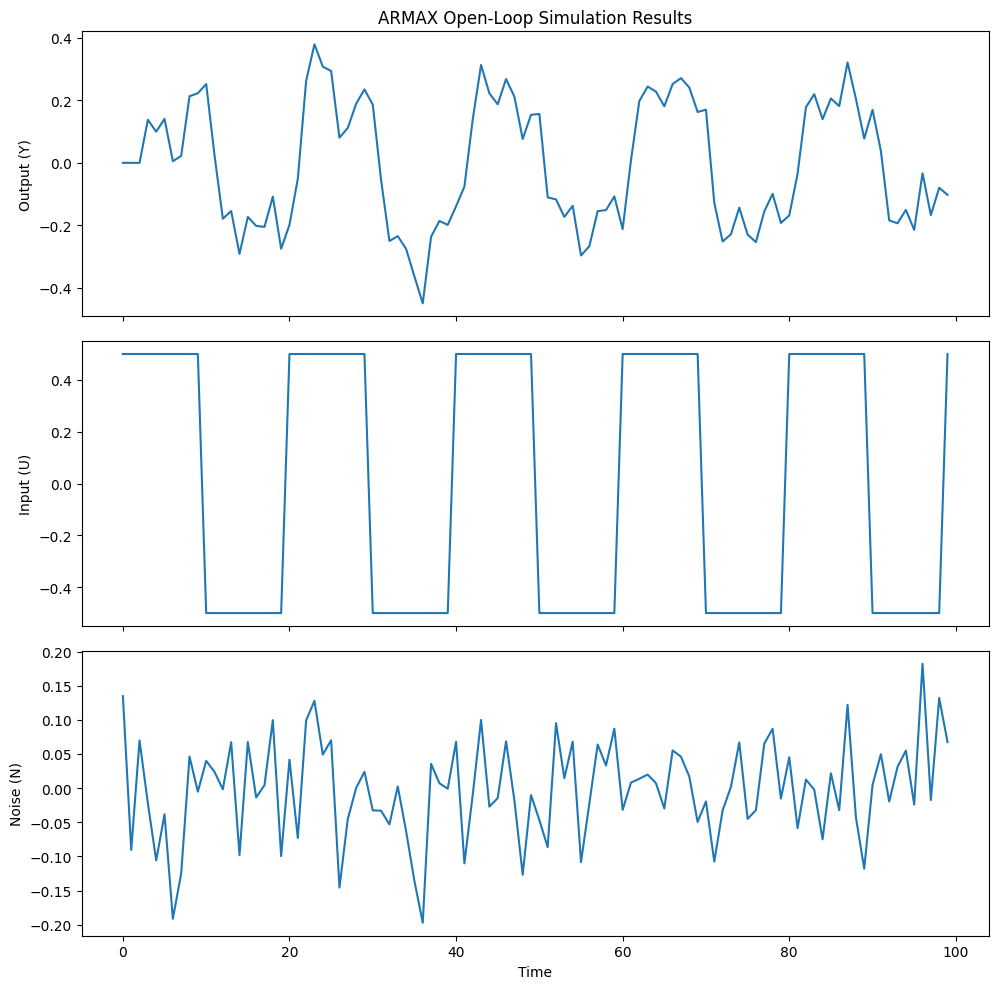

(2, 100) (1, 100)


In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

class ARMAX:
    def __init__(self, A, B, C):
        self.A = np.array(A)
        self.B = np.array(B)
        self.C = np.array(C)
    
    def simulate_open_loop(self, n_samples, U=None, noise_std=0.1):
        Y = np.zeros(n_samples)
        N = np.random.normal(0, noise_std, n_samples)
        
        if U is None:
            U = np.zeros(n_samples)
        
        max_order = max(len(self.A), len(self.B), len(self.C))
        
        for t in range(max_order, n_samples):
            Y[t] = (- np.dot(self.A[1:], Y[t-1:t-len(self.A):-1]) 
                    + np.dot(self.B, U[t-1:t-len(self.B)-1:-1])
                    + np.dot(self.C, N[t:t-len(self.C):-1]))
        
        return Y, U, N

    def plot_results(self, Y, U, N, R=None):
        fig, axs = plt.subplots(4 if R is not None else 3, 1, figsize=(10, 10), sharex=True)
        
        axs[0].plot(Y)
        axs[0].set_ylabel('Output (Y)')
        axs[0].set_title('ARMAX Open-Loop Simulation Results')
        
        axs[1].plot(U)
        axs[1].set_ylabel('Input (U)')
        
        axs[2].plot(N)
        axs[2].set_ylabel('Noise (N)')
        
        if R is not None:
            axs[3].plot(R)
            axs[3].set_ylabel('Reference (R)')
            axs[3].set_xlabel('Time')
        else:
            axs[2].set_xlabel('Time')
        
        plt.tight_layout()
        plt.show()

# Example usage
A = [1, -0.33, 0.1]   # A(z^-1) = 1 - 0.33z^-1 + 0.1z^-2
B = [0.22, 0.1]       # B(z^-1) = 0.22z^-1 + 0.1z^-2
C = [1]               # 

armax_model = ARMAX(A, B, C)

n_samples = 100
U = 0.5 * signal.square(np.linspace(0, 10*np.pi, n_samples))  # External input signal

Y, U, noise = armax_model.simulate_open_loop(n_samples, U, noise_std=0.07)
armax_model.plot_results(Y, U, noise)  # No R needed for open-loop

Y_dot = np.gradient(Y)

U = U.reshape(1, -1)
Y = np.vstack([Y, Y_dot])
print(Y.shape, U.shape)


In [54]:
params = np.array([-0.33, 0.1, 0.22, 0.1])
A_obs, B_obs, C_obs, D_obs, A,B = _construct_ss_from_params(params,C_obs)
G = d_tfs.ss_to_tf(A_obs, B_obs, C_obs, D_obs, check_assumption=False)
C = np.empty((n_output, 1))
H = np.zeros((n_output, n_output), dtype=object)
for i in range(n_output):
    C[i]=np.array([1.0])
    H[i,i]=d_tfs((np.array([1.0]),A))
print("A_obs: ", A_obs)
print("B_obs:",  B_obs)
print("C_obs: ", C_obs)
print("A",A)
print("B", B)
print(G)
print(H)
print(C)
open_loop_sps_mimo(G, H, A, B, C, Y, U)

A_obs:  [[ 0.   -0.1 ]
 [ 1.    0.33]]
B_obs: [[0.1 ]
 [0.22]]
C_obs:  [[0 1]
 [1 0]]
A [ 1.   -0.33  0.1 ]
B [[0.   0.22 0.1 ]]
[[Transfer Function: num=[0.   0.22 0.1 ], den=[ 1.   -0.33  0.1 ]]
 [Transfer Function: num=[ 0.     0.1   -0.055], den=[ 1.   -0.33  0.1 ]]]
[[Transfer Function: num=[1.], den=[ 1.   -0.33  0.1 ] 0]
 [0 Transfer Function: num=[1.], den=[ 1.   -0.33  0.1 ]]]
[[1.]
 [1.]]
(2, 100)
(100, 4, 2, 50) (100, 50, 4, 2)
(100, 4, 4)
(100, 2, 50)


False

## 2 input 2 output

In [ ]:
A = np.array([1, 0.3, -0.2])    # a1, a2
B = np.array([[0, 0.5, 0.1], [0, 0.8, 0.1]])     # b1, b2
C = np.array([[1, 0.5],[1, 0.8]])          # c1
